In [1]:
import mne
import numpy as np

In [2]:
edf_file_path = r'15089_2017_08_14_EEG\0_20170814_161604.edf'  
raw = mne.io.read_raw_edf(edf_file_path, preload=True)
raw

Extracting EDF parameters from c:\Users\91820\Downloads\drive-download-20240708T114910Z-001\15089_2017_08_14_EEG\0_20170814_161604.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1230449  =      0.000 ...  4921.796 secs...


<RawEDF | 0_20170814_161604.edf, 32 x 1230450 (4921.8 s), ~300.4 MB, data loaded>

In [9]:
print(raw.ch_names)


['T4', 'A2', 'C3', 'C4', 'A1', 'T3', 'O1', 'T5', 'O2', 'EKG2', 'F8', 'T6', 'FZ', 'FP2', 'F7', 'FP1', 'CZ', 'F3(BLUE)', 'F4(RED)', '20', '9', '22', '23', '24', '25', 'CH26', 'CH27', 'CH28', 'CH29', 'CH30', 'CH31', 'CH32']


In [55]:
from sklearn.linear_model import LinearRegression
from mne.preprocessing import ICA
import mne

def preprocess(edf_file_path, l_freq=1.0, h_freq=40.0):
    raw = mne.io.read_raw_edf(edf_file_path, preload=True)
    
    raw.set_eeg_reference(ref_channels=['CZ'])

    raw.filter(l_freq=l_freq, h_freq=h_freq)

    # Extract 'EKG2' as the artifact channel
    ekg_data = raw.copy().pick_channels(['EKG2']).get_data()

    # Apply ICA for artifact removal
    ica = ICA(n_components=20, random_state=97, max_iter=800)  # Adjust n_components as needed
    ica.fit(raw)

    ekg_idx, scores = ica.find_bads_ecg(raw, ch_name='EKG2')
    ica.exclude = ekg_idx  # Mark these components for exclusion

    raw_ica_cleaned = ica.apply(raw.copy())

    channels_of_interest = ['FP1', 'FP2', 'F7', 'F8']
    raw_final = raw_ica_cleaned.copy().pick_channels(channels_of_interest)

    raw_final.apply_hilbert()

    events, event_id = mne.events_from_annotations(raw_final)
    epochs = mne.Epochs(raw_final, events, event_id, tmin=0, tmax=1.0, baseline=None, preload=True)
    raw_final.plot()
    return raw_final, epochs


Extracting EDF parameters from c:\Users\91820\Downloads\drive-download-20240708T114910Z-001\15089_2017_08_14_EEG\0_20170814_161604.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1230449  =      0.000 ...  4921.796 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 70.9s.
Using threshold: 0.32 for CTPS ECG detection
Using channel EKG2 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 3905 (average pulse 47.604534926246494 / min.)
Not setting metadata
3905 matching events found
No baseline correction applied
Using data from preloaded Raw for 3905 events an

C:\Users\91820\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


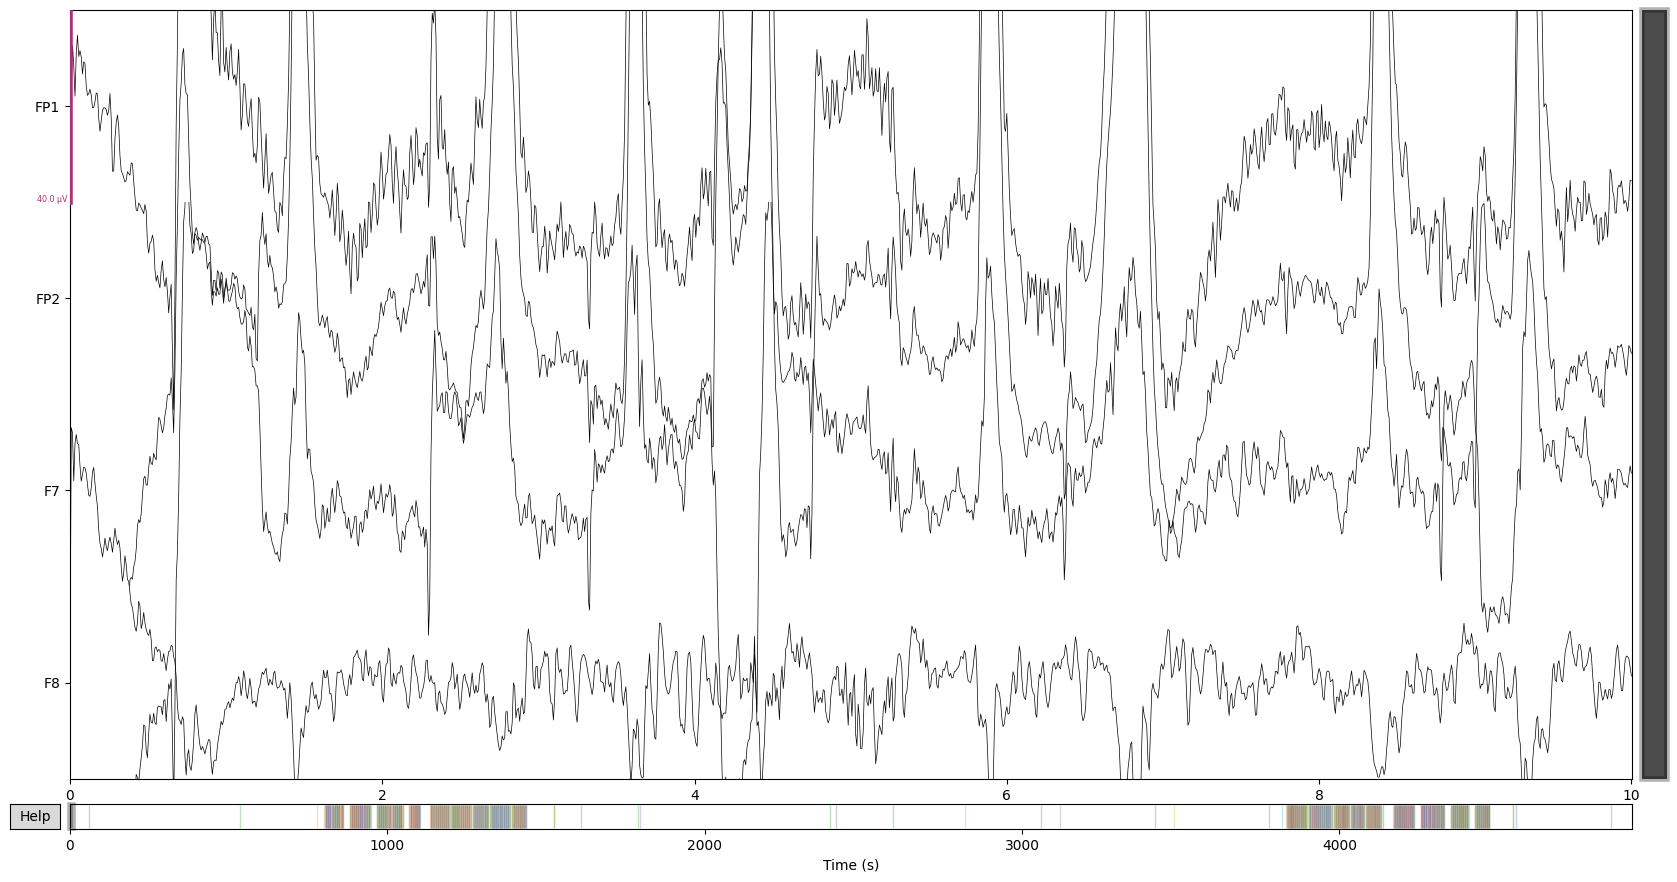

In [60]:
prcesssed_data,epchs=preprocess(edf_file_path)

In [62]:
epchs.get_data().shape

(1003, 4, 251)

In [84]:
import numpy as np
from sklearn.model_selection import train_test_split

raw_final=prcesssed_data
# Get the total recording time of the EEG
max_time = raw_final.times[-1]

# Define time intervals for no stress and stress conditions
tmax1 = min(max_time, 600)    # No stress interval end time (10 minutes)
tmax2 = min(max_time, 1860)   # Stress interval end time (31 minutes)
tmin1 = min(300, max_time)    # No stress interval start time (5 minutes)
tmin2 = min(1500, max_time)   # Stress interval start time (25 minutes)

# Extract the intervals
no_stress_interval = raw_final.copy().crop(tmin=tmin1, tmax=tmax1)
stressed_interval = raw_final.copy().crop(tmin=tmin2, tmax=tmax2)

# Get the data from the intervals
no_stress_data = no_stress_interval.get_data()
stressed_data = stressed_interval.get_data()

# Ensure both datasets have the same number of samples (crop to minimum length)
min_length = min(no_stress_data.shape[1], stressed_data.shape[1])
no_stress_data = no_stress_data[:, :min_length]
stressed_data = stressed_data[:, :min_length]
sfreq=raw_final.info['sfreq']
no_stress_duration_samples = int((tmax1 - tmin1) * sfreq)
stress_duration_samples = int((tmax2 - tmin2) * sfreq)
print(no_stress_duration_samples)
# Reshape the data for CNN input (samples, channels, time, 1)
no_stress_data = no_stress_data.reshape((1, no_stress_data.shape[0], no_stress_data.shape[1], 1))
stressed_data = stressed_data.reshape((1, stressed_data.shape[0], stressed_data.shape[1], 1))
print(no_stress_data.shape)
print(stressed_data.shape)
# Combine the no stress and stress data
data = np.concatenate((no_stress_data, stressed_data), axis=0)
data = data.reshape((data.shape[2], data.shape[1],2 , 1))
print(data.shape)

# Create labels: 0 for no stress, 1 for stress
labels = np.array([0] * no_stress_data.shape[2] + [1] * stressed_data.shape[2])
print(labels.shape)
# Use train_test_split for an 80-20 split and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, shuffle=True
)

# Reshape the data to match EEGNet's expected input (samples, channels, time, 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Return the prepared train and test sets
# return X_train, X_test, y_train, y_test


75000
(1, 4, 75001, 1)
(1, 4, 75001, 1)
(75001, 4, 2, 1)
(150002,)


ValueError: Found input variables with inconsistent numbers of samples: [75001, 150002]

In [77]:
# X_train, X_test, y_train, y_test=process_for_cnn(prcesssed_data)
print(X_train.shape)
X_test.shape

(75001, 4, 2, 1)
(150002,)


ValueError: Found input variables with inconsistent numbers of samples: [75001, 150002]

In [46]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans=4, Samples=128, dropoutRate=0.5, kernLength=64, F1=16, D=2, F2=32, norm_rate=0.25, dropoutType='Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1 = Input(shape=(Chans, Samples, 1))

    ##################################################################
    # Block 1
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D)(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    ##################################################################
    # Block 2
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    ##################################################################
    # Additional Block (Block 3)
    block3 = SeparableConv2D(F2, (1, 32), use_bias=False, padding='same')(block2)
    block3 = BatchNormalization()(block3)
    block3 = Activation('elu')(block3)
    block3 = AveragePooling2D((1, 4))(block3)
    block3 = dropoutType(dropoutRate)(block3)

    flatten = Flatten(name='flatten')(block3)

    dense = Dense(nb_classes, name='dense', kernel_constraint=max_norm(norm_rate))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    return Model(inputs=input1, outputs=softmax)


In [47]:
from tensorflow.keras.utils import to_categorical
def apply_cnn_pipeline(edf_file_path):
    # Step 1: Process the EEG data
    data=preprocess(edf_file_path)
    X_train, X_test, y_train, y_test = process_for_cnn(data)
    
    # Ensure that the labels are one-hot encoded
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    # Step 2: Build the EEGNet model
    model = EEGNet(nb_classes=y_train.shape[1], Chans=X_train.shape[1], Samples=X_train.shape[2])
    
    # Compile the model with categorical cross-entropy and accuracy metrics
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Step 3: Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

    # Step 4: Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Extracting EDF parameters from c:\Users\91820\Downloads\drive-download-20240708T114910Z-001\15089_2017_08_14_EEG\0_20170814_161604.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1230449  =      0.000 ...  4921.796 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 71.2s.
Using threshold: 0.32 for CTPS ECG detection
Using channel EKG2 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 3905 (average pulse 47.604534926246494 / min.)
Not setting metadata
3905 matching events found
No baseline correction applied
Using data from preloaded Raw for 3905 events an

C:\Users\91820\AppData\Roaming\Python\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


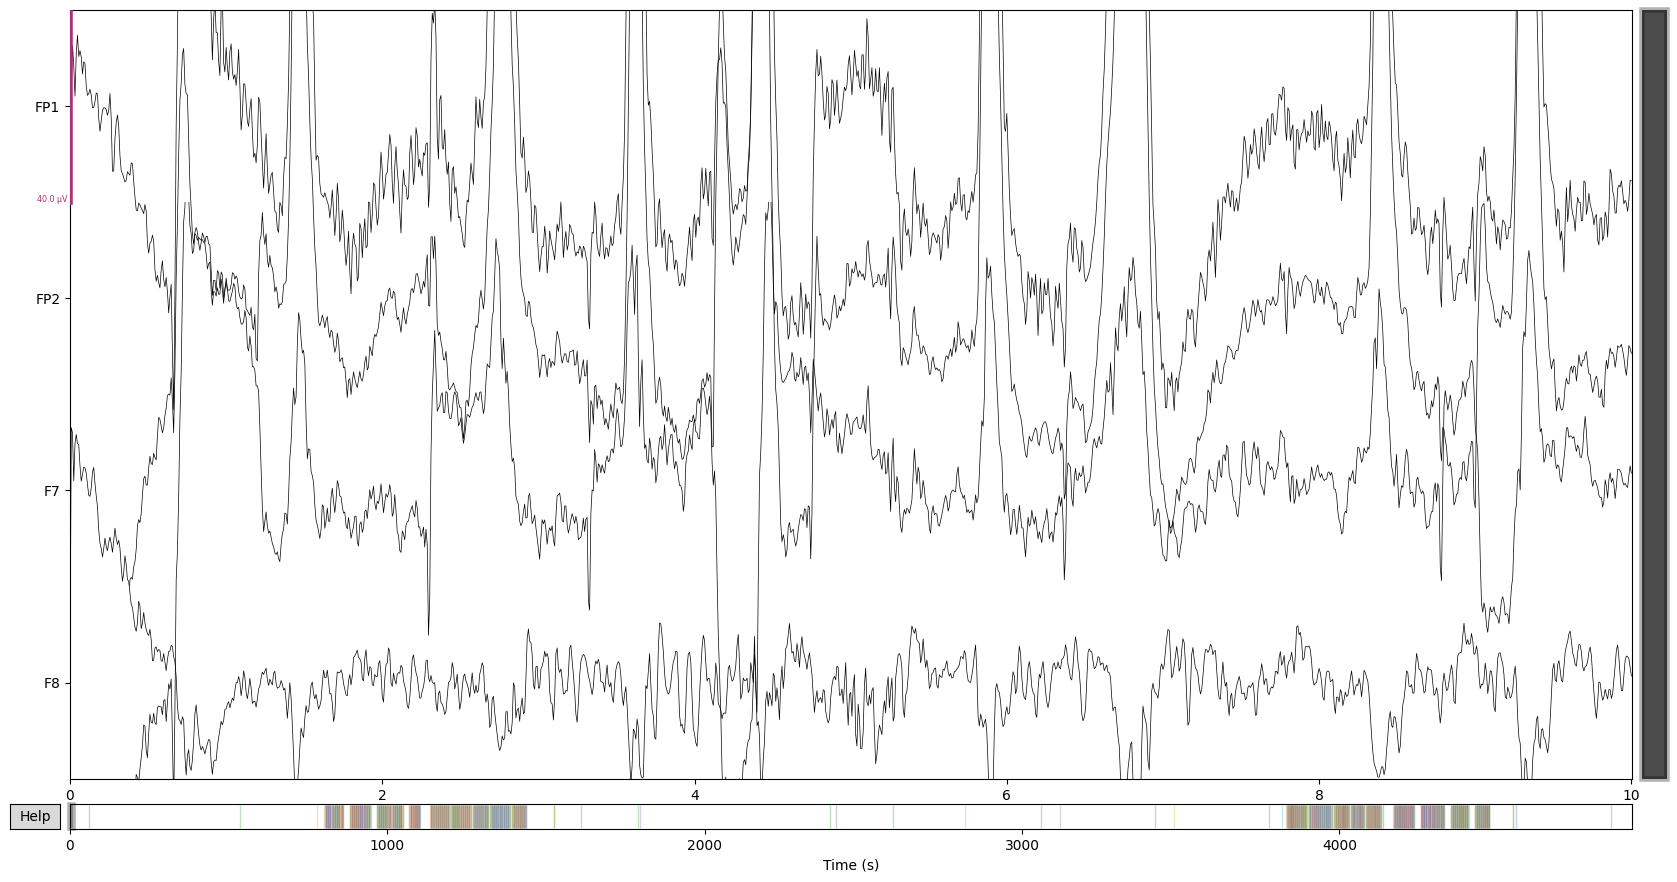

IndexError: tuple index out of range

In [48]:
apply_cnn_pipeline(edf_file_path)